# 멀티 에이전트 감독자(Multi-Agent Supervisor)

이 튜토리얼에서는 **LangGraph**를 활용하여 다중 에이전트 시스템을 구축하고, 에이전트 간 작업을 효율적으로 조정하고 감독자(Supervisor)를 통해 관리하는 방법을 살펴봅니다.  
여러 에이전트를 동시에 다루며, 각 에이전트가 자신의 역할을 수행하도록 관리하고, 작업 완료 시 이를 적절히 처리하는 과정을 다룹니다.

---

**개요**

이전 튜토리얼에서는 초기 연구자(Researcher) 에이전트의 출력에 따라 메시지를 자동으로 라우팅하는 방식을 보여주었습니다.  
그러나 에이전트가 여러 개로 늘어나고, 이들을 조정해야 할 경우, 단순한 분기 로직만으로는 한계가 있습니다.  
여기서는 [LLM을 활용한 Supervisor](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor)를 통해 에이전트들을 관리하고, 각 에이전트 노드의 결과를 바탕으로 팀 전체를 조율하는 방법을 소개합니다.

**중점 사항**:  
- Supervisor는 다양한 전문 에이전트를 한 데 모아, 하나의 팀(team)으로 운영하는 역할을 합니다.  
- Supervisor 에이전트는 팀의 진행 상황을 관찰하고, 각 단계별로 적절한 에이전트를 호출하거나 작업을 종료하는 등의 로직을 수행합니다.

![](./assets/langgraph-multi-agent-supervisor.png)

---

**이 튜토리얼에서 다룰 내용**

- **설정(Setup)**: 필요한 패키지 설치 및 API 키 설정 방법  
- **도구 생성(Tool Creation)**: 웹 검색 및 플롯(plot) 생성 등, 에이전트가 사용할 도구 정의  
- **도우미 유틸리티(Helper Utilities)**: 에이전트 노드 생성에 필요한 유틸리티 함수 정의  
- **에이전트 감독자 생성(Creating the Supervisor)**: 작업자(Worker) 노드의 선택 및 작업 완료 시 처리 로직을 담은 Supervisor 생성  
- **그래프 구성(Constructing the Graph)**: 상태(State) 및 작업자(Worker) 노드를 정의하여 전체 그래프 구성  
- **팀 호출(Invoking the Team)**: 그래프를 호출하여 실제로 다중 에이전트 시스템이 어떻게 작동하는지 확인

이 과정에서 LangGraph의 사전 구축된 [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent) 함수를 활용해, 각 에이전트 노드를 간소화합니다. 

이러한 "고급 에이전트" 사용 방식은 LangGraph에서의 특정 디자인 패턴을 시연하기 위한 것이며, 필요에 따라 다른 기본 패턴과 결합하여 최적의 결과를 얻을 수 있습니다.

---

**참고**

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)  
- [멀티 에이전트 Supervisor 개념](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor)  
- [create_react_agent 함수 문서화](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


본 튜토리얼에 사용할 모델명을 설정합니다.

In [3]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 버전의 모델명을 가져옵니다.
#MODEL_NAME = get_model_name(LLMs.GPT4)
MODEL_NAME = "gemini-2.5-pro"
print(MODEL_NAME)

gemini-2.5-pro


## 상태 정의

멀티 에이전트 시스템에서 활용할 상태(state)를 정의합니다.

In [4]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지
    next: str  # 다음으로 라우팅할 에이전트

## 에이전트 생성

### 도구(tool) 생성

이 예제에서는 검색 엔진을 사용하여 웹 조사를 수행하는 에이전트와 플롯을 생성하는 에이전트를 만듭니다. 

아래에 사용할 도구를 정의합니다.

- **Research**: `TavilySearch` 도구를 사용하여 웹 조사를 수행합니다.
- **Coder**: `PythonREPLTool` 도구를 사용하여 코드를 실행합니다.

In [5]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_experimental.tools import PythonREPLTool

# 최대 5개의 검색 결과를 반환하는 Tavily 검색 도구 초기화
tavily_tool = TavilySearch(max_results=5)

# 로컬에서 코드를 실행하는 Python REPL 도구 초기화 (안전하지 않을 수 있음)
python_repl_tool = PythonREPLTool()

## Agent 생성하는 Utility 구현

LangGraph를 사용하여 다중 에이전트 시스템을 구축할 때, **도우미 함수**는 에이전트 노드를 생성하고 관리하는 데 중요한 역할을 합니다. 이러한 함수는 코드의 재사용성을 높이고, 에이전트 간의 상호작용을 간소화합니다.

- **에이전트 노드 생성**: 각 에이전트의 역할에 맞는 노드를 생성하기 위한 함수 정의
- **작업 흐름 관리**: 에이전트 간의 작업 흐름을 조정하고 최적화하는 유틸리티 제공
- **에러 처리**: 에이전트 실행 중 발생할 수 있는 오류를 효율적으로 처리하는 메커니즘 포함

다음은 `agent_node`라는 함수를 정의하는 예시입니다. 

이 함수는 주어진 상태와 에이전트를 사용하여 에이전트 노드를 생성합니다. 이 함수를 나중에 `functools.partial`을 사용하여 호출할 것입니다.

In [6]:
from langchain_core.messages import HumanMessage


# 지정한 agent와 name을 사용하여 agent 노드를 생성
def agent_node(state, agent, name):
    # agent 호출
    agent_response = agent.invoke(state)
    # agent의 마지막 메시지를 HumanMessage로 변환하여 반환
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

**참고**

`functools.partial`의 역할

`functools.partial`은 기존 함수의 일부 인자 또는 키워드 인자를 미리 고정하여 새 함수를 생성하는 데 사용됩니다. 즉, 자주 사용하는 함수 호출 패턴을 간소화할 수 있도록 도와줍니다.

**역할**

1. **미리 정의된 값으로 새 함수 생성**: 기존 함수의 일부 인자를 미리 지정해서 새 함수를 반환합니다.
2. **코드 간결화**: 자주 사용하는 함수 호출 패턴을 단순화하여 코드 중복을 줄입니다.
3. **가독성 향상**: 특정 작업에 맞춰 함수의 동작을 맞춤화해 더 직관적으로 사용 가능하게 만듭니다.

>예시코드
```python
research_node = functools.partial(agent_node, agent=research_agent, names="Researcher")
```

1. `agent_node`라는 기존 함수가 있다고 가정합니다.
   - 이 함수는 여러 개의 인자와 키워드 인자를 받을 수 있습니다.

2. `functools.partial`은 이 함수에 `agent=research_agent`와 `names="Researcher"`라는 값을 고정합니다.
   - 즉, 이제 `research_node`는 `agent_node`를 호출할 때 `agent`와 `names` 값을 따로 지정하지 않아도 됩니다.
   - 예를 들어:
     ```python
     agent_node(state, agent=research_agent, names="Researcher")
     ```
     대신,
     ```python
     research_node(state)
     ```
     처럼 사용할 수 있습니다.

아래는 `functools.partial`을 사용하여 `research_node`를 생성하는 예시입니다.

In [ ]:
import functools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
# Research Agent 생성
research_agent = create_react_agent(ChatGoogleGenerativeAI(model=MODEL_NAME), tools=[tavily_tool])

# research node 생성
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [ ]:
# import functools
# from langgraph.prebuilt import create_react_agent
# from langchain_openai import ChatOpenAI
# from langchain_google_genai import ChatGoogleGenerativeAI


# # Research Agent 생성
# research_agent = create_react_agent(ChatOpenAI(model="gpt-4o"), tools=[tavily_tool])

# # research node 생성
# research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

코드를 실행하여 결과를 확인합니다.

In [9]:
research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)

{'messages': [HumanMessage(content='To print "Hello, World!" to the terminal using different programming languages, you can use the following code snippets:\n\n### Python\n```python\nprint("Hello, World!")\n```\n\n### JavaScript (Node.js)\n```javascript\nconsole.log("Hello, World!");\n```\n\n### Java\n```java\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```\n\n### C\n```c\n#include <stdio.h>\n\nint main() {\n    printf("Hello, World!\\n");\n    return 0;\n}\n```\n\n### C++\n```cpp\n#include <iostream>\n\nint main() {\n    std::cout << "Hello, World!" << std::endl;\n    return 0;\n}\n```\n\n### Go\n```go\npackage main\n\nimport "fmt"\n\nfunc main() {\n    fmt.Println("Hello, World!")\n}\n```\n\n### Ruby\n```ruby\nputs "Hello, World!"\n```\n\n### PHP\n```php\n<?php\necho "Hello, World!";\n?>\n```\n\nYou can run the respective code snippets in their appropriate environments to print "Hello, World!" to the

### Agent Supervisor 생성

에이전트를 관리 감독하는 감독자 에이전트를 생성합니다.

In [10]:
from pydantic import BaseModel
from typing import Literal

# 멤버 Agent 목록 정의
members = ["Researcher", "Coder"]

# 다음 작업자 선택 옵션 목록 정의
options_for_next = ["FINISH"] + members


# 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [11]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# ChatPromptTemplate 생성
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))


# LLM 초기화
llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)


# Supervisor Agent 생성
def supervisor_agent(state):
    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    # Agent 호출
    return supervisor_chain.invoke(state)

## 그래프 구성

이제 그래프를 구축할 준비가 되었습니다. 아래에서는 방금 정의한 함수를 사용하여 `state`와 `worker` 노드를 정의합니다.

In [12]:
import functools
from langgraph.prebuilt import create_react_agent


# Research Agent 생성
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""


# Coder Agent 생성
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

In [13]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(AgentState)

# 그래프에 노드 추가
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)


# 멤버 노드 > Supervisor 노드로 엣지 추가
for member in members:
    workflow.add_edge(member, "Supervisor")

# 조건부 엣지 추가 (
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END


def get_next(state):
    return state["next"]


# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화합니다.

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

그래프 시각화 실패 (추가 종속성 필요): Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`
ASCII로 그래프 표시:
                   +-----------+                      
                   | __start__ |                      
                   +-----------+                      
                          *                           
                          *                           
                          *                           
                  +------------+                      
                  | Supervisor |                      
                 .+------------+...                   
              ...        *         ...                


## 팀 호출

생성된 그래프를 통해 이제 성능을 확인할 수 있습니다.


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (b807c343-5053-432d-b8e8-a7d22bdec227)
 Call ID: b807c343-5053-432d-b8e8-a7d22bdec227
  Args:
    query: 대한민국 1인당 GDP 2010-2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"url": "https://www.hani.co.kr/arti/economy/economy_general/1208176.html", "title": "상호의존 속 추격자 한국, 2024년 1인당 GDP 일본 추월 - 한겨레", "content": "### 상호의존 속 추격자 한국, 2024년 1인당 GDP 일본 추월 1952년 1인당 국민소득이 전쟁 이전 수준을 회복했다. 그런 대일 정책은 중국 공산당의 대륙 제패 가능성이 높아진 1947년 이후 ‘향후 극동에 발생할 전체주의적 전쟁 위협의 저지 역할’을 위해 일본을 재건하는 쪽으로 대전환했다. 1965년 한-일 어업협정이 체결될 때까지 평화선을 침범한 일본 어선 328척을 나포하고, 어부 3929명을 억류했다. 1963~1979년 한국 경제성

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (95242cd8-119b-48bc-93dc-0b7796e47330)
 Call ID: 95242cd8-119b-48bc-93dc-0b7796e47330
  Args:
    query: 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import pandas as pd

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

# 마이너스 폰트 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 데이터 생성

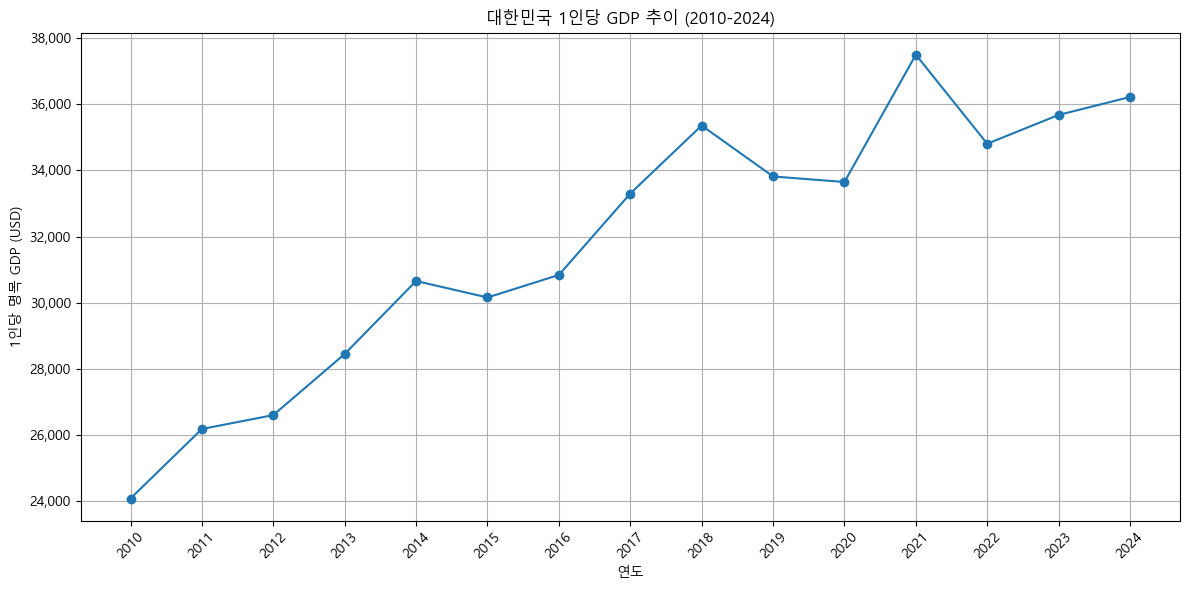


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

['다음은 2010년부터 2024년까지 대한민국의 1인당 GDP 추이를 시각화한 그래프와 코드입니다.\n\n### 대한민국 1인당 GDP 추이 (2010-2024)', '\n\n그래프에서 볼 수 있듯이, 대한민국의 1인당 명목 GDP는 2010년 약 $24,000에서 2024년 약 $36,000에 이르기까지 장기적으로 꾸준히 성장하는 추세를 보입니다. 중간에 2015년, 2019년, 2022년 등 몇 차례 소폭의 하락이 있었지만, 전반적으로는 우상향하는 모습을 명확하게 확인할 수 있습니다.\n\n### 그래프 생성 코드', '```python\nimport matplotlib.pyplot as plt\nimport matplotlib.font_manager as fm\nimport platform\nimport pandas as pd\n\n##### 폰트 설정 #####\n# OS 판단\ncurrent_os = platform.system()\n\nif current_os == "Windows":\n    # Windows 환경 폰트 설정\n    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로\n    fontprop = fm.FontProperties(fname=font_path, size=12)\n   

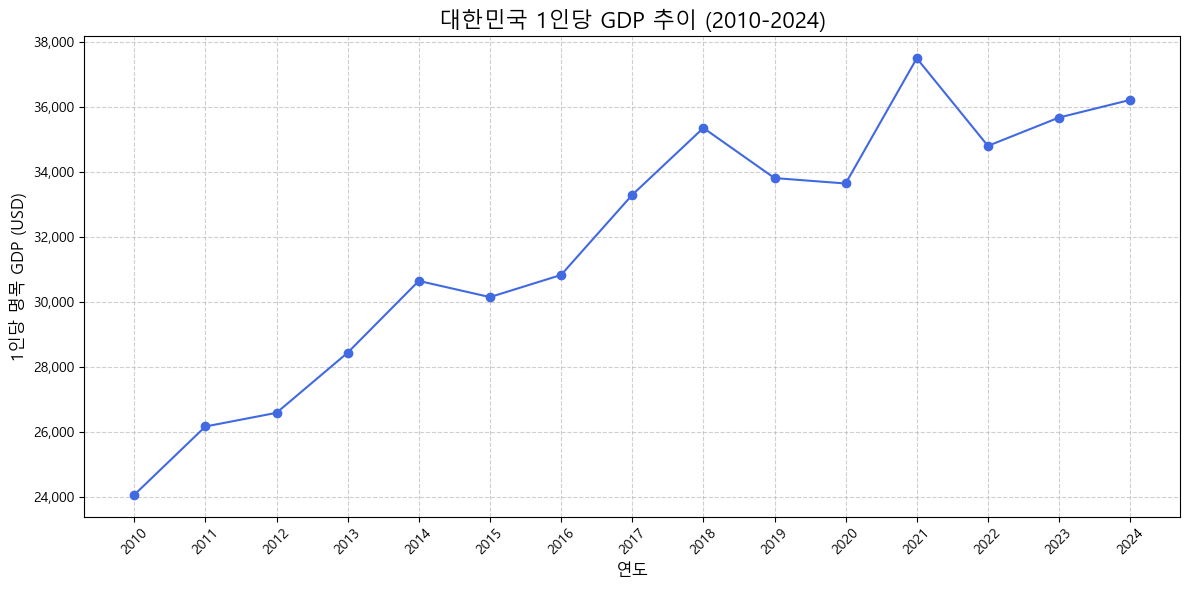


🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (95aa4d69-f891-4203-b1fa-e8c2d2437503)
 Call ID: 95aa4d69-f891-4203-b1fa-e8c2d2437503
  Args:
    query: 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import pandas as pd

##### 폰트 설정 #####
# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unico

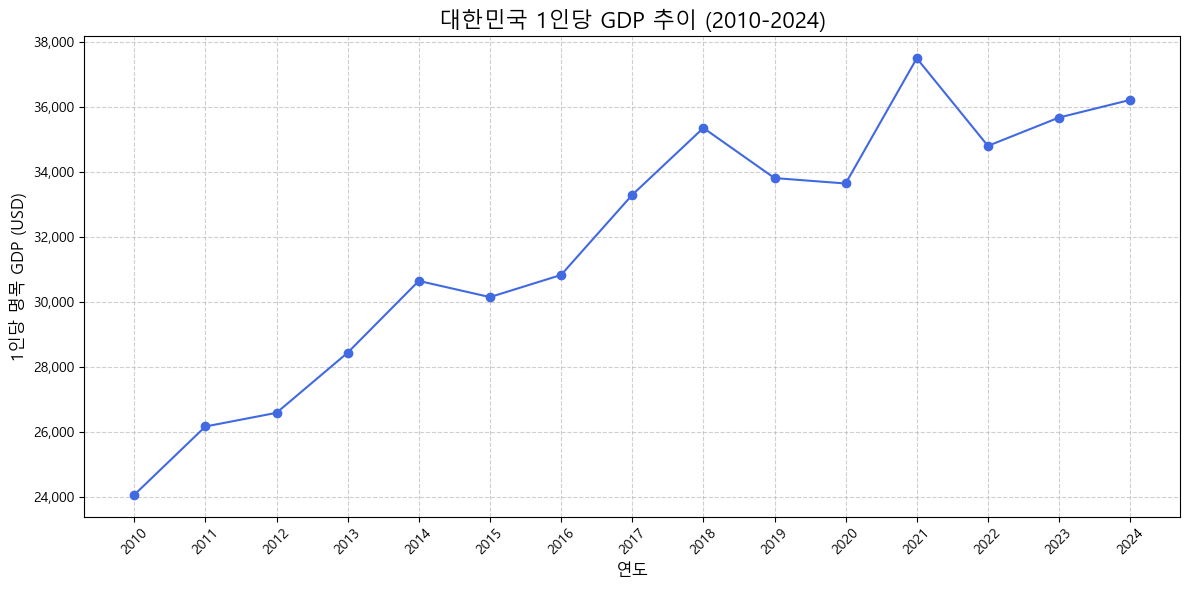


🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (b5125bbb-afa9-4590-892a-9f4ab7769157)
 Call ID: b5125bbb-afa9-4590-892a-9f4ab7769157
  Args:
    query: 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import pandas as pd

##### 폰트 설정 #####
# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unico

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)